Simple FWI Example
==================

In this section we see application of PyFWI for performing FWI.
First, forward modeling is shown and then we estimate a model of subsurface using FWI.


 **1. Forward modeling**



In this simple example, we use PyFWI to do forward modeling. So, we need to first import the following packages amd modulus.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md
import PyFWI.fwi_tools as tools
import PyFWI.processing as process
from PyFWI.fwi import FWI



A simple model can be created by using ```model_dataset``` module as

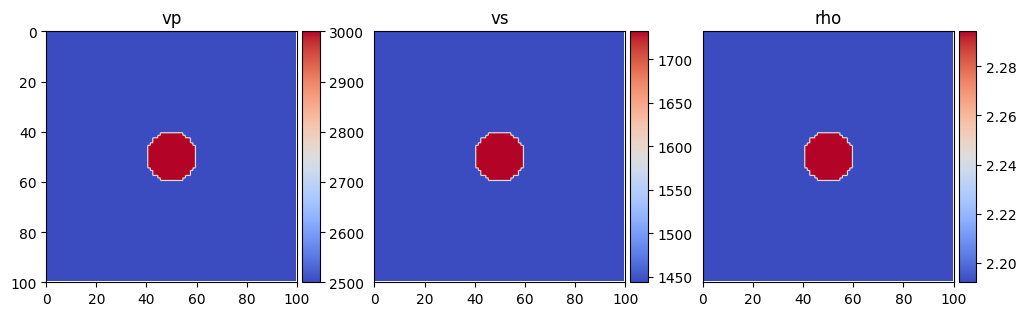

In [2]:
Model = md.ModelGenerator('louboutin')
model = Model()

im = splt.earth_model(model, cmap='coolwarm')

Then we need to create an input dictionary as follow

In [3]:
model_shape = model[[*model][0]].shape

inpa = {
    'ns': 4,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 7,  # Spatial sampling rate
    'dt': 0.004,  # Temporal sampling rate
    'acq_type': 0,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.6,  # Length of operation
    'npml': 20,  # Number of PML 
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
    # 'device': 1, # The device to run the program. Usually 0: CPU 1: GPU
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


Now, we obtain the location of sources and receivers based on specified parameters.

In [4]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'], 
                                                                 inpa['rec_dis'], 
                                                                 offsetx,
                                                                 depth,
                                                                 inpa['dh'], 
                                                                 inpa['sdo'], 
                                                                 acq_type=inpa['acq_type'])        
# src_loc[:, 1] -= 5 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])


Finally, we can have the forward modelling as 

In [5]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling 
d_obs = W.forward_modeling(model, show=False)  # show=True can show the propagation of the wave

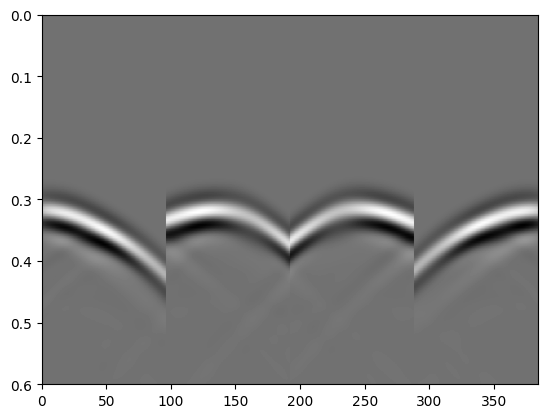

In [6]:
plt.imshow(d_obs["taux"], cmap='gray', 
           aspect="auto", extent=[0, d_obs["taux"].shape[1], inpa['t'], 0])

**2. FWI**

To perform FWI, we need the observed data and an initial model. 


**Note:** For better visualization and avoiding crosstalk, I estimate the model in acoustic media.

Here is a homogeneous initial model.

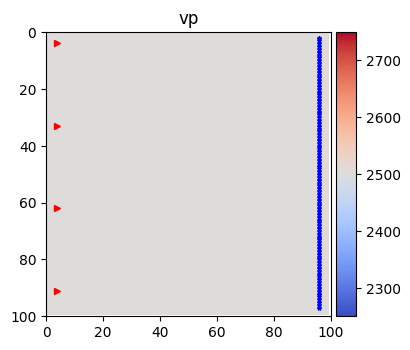

In [7]:
m0 = Model(smoothing=1)
m0['vs'] *= 0.0
m0['rho'] = np.ones_like(model['rho'])

fig = splt.earth_model(m0, ['vp'], cmap='coolwarm')

fig.axes[0].plot(src_loc[:,0]//inpa["dh"], 
                 src_loc[:,1]//inpa["dh"], "r>", markersize=5)

fig.axes[0].plot(rec_loc[:,0]//inpa["dh"], 
                 rec_loc[:,1]//inpa["dh"], "b*", markersize=3)


Now, we can create a FWI object,

In [8]:
fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)


and call it by providing the initial model `m0`, observed data `d_obs`, optimization method `method`, desired frequencies for inversion, number of iterations for each frequency, number of parameters for inversion `n_params`, index of the first parameter `k_0`, and index of the last parameter `k_end`.
For example, if we have an elastic model, but we want to only invert for P-wave velocity, these parameters should be defined as
```python
n_params = 1
k_0 = 1
k_end = 2
```

If we want to invert for P-wave velocity and then $V_S$, these parameters should be defined as
```python
n_params = 1
k_0 = 1
k_end = 3
```
and for simultaneously inverting for these two parameters, we define these parameters as 
```python
n_params = 2
k_0 = 1
k_end = 3
```

Let's call the FWI object,


In [9]:
m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.00031876127468422055 with rms_reg: 0, and rms_data: 0.00031876127468422055, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
Parameter number 1 to 1
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18761D-04    |proj g|=  7.60487D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      0      1      0     0     0   7.605D-10   3.188D-04
  F =   3.1876127468422055E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.


2500.0 2500.0
 for f= 45: rms is: 0.004415073432028294 with rms_reg: 0, and rms_data: 0.004415073432028294, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41507D-03    |proj g|=  2.60689D-08


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -6.3524D-13  6.3524D-13
Distance to the stationary point =   1.0000D+00

---------------- exit CAUCHY----------------------

       10000  variables are free at GCP            1


 This problem is unconstrained.


2499.9817678114177 2500.0327078217074
 for f= 45: rms is: 0.0044143591076135635 with rms_reg: 0, and rms_data: 0.0044143591076135635, rms_mp: 0.0, rms_model_relation: 0
2499.9088390570896 2500.1635391085365
 for f= 45: rms is: 0.004411503206938505 with rms_reg: 0, and rms_data: 0.004411503206938505, rms_mp: 0.0, rms_model_relation: 0
2499.617124039776 2500.686864255853
 for f= 45: rms is: 0.004400103818625212 with rms_reg: 0, and rms_data: 0.004400103818625212, rms_mp: 0.0, rms_model_relation: 0
2498.4502639705233 2502.780164845119
 for f= 45: rms is: 0.004354970529675484 with rms_reg: 0, and rms_data: 0.004354970529675484, rms_mp: 0.0, rms_model_relation: 0
2493.7828236935106 2511.153367202184
 for f= 45: rms is: 0.004181776195764542 with rms_reg: 0, and rms_data: 0.004181776195764542, rms_mp: 0.0, rms_model_relation: 0
2475.113062585461 2544.6461766304446
 for f= 45: rms is: 0.0036037799436599016 with rms_reg: 0, and rms_data: 0.0036037799436599016, rms_mp: 0.0, rms_model_relation: 0

Here is the estimated model

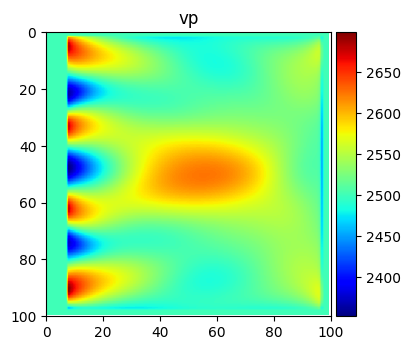

In [10]:
# Time to plot the results
fig = splt.earth_model(m_est, ['vp'], cmap='jet')
